# In depth: Manifold Learning

We have seen how principal component analysis (PCA) can be used in the dimensionality reduction task - reducing the number of features of a dataset while maintaining the essential relationships between the points. While PCA is lfexible, fast, and easily interpretable, it does not perform so well when tere are *nonlinear* relationships within the data; we will see some examples of these below.

To address this deficiency, we can turn to a class of methods known as *manifold learning* - a class of unsupervised estimators that seeks to desctibe datasets as low-dimensional manifolds embedded in high-dimensional spaces. When you think of a manifold, I'd suggest imagining a sheet of paper: this is a two-dimensional object that lives in our familiear three-dimensional world, and can be bent or rollled in that two dimensions. In the parlance of manifodl learning, we can think of this sheet as a two-dimensional manigold embedded in three-dimensional space.

Rotating, re-orienting, or stertching the piece of paper in three-dimensional space doesn't change the falt geomtry of the paper: such operations are akin to linear embeddings. If you bend, curl, or crumple the paper, it is still a two-dimensional manifold, but the embedding into the three-dimensional space is no longer linear. Manifold learning algorithms would seek to learn about the fundamental two-dimensional nature of the paper, even as it is contornted to fill the three-dimensional space.

Here we will demonstrate a number of manifold methods, going most deeply into a couple techniques: multidimensional scalin(MDS), locally linear embedding (LLE), and siometric mapping (IsoMap).

We begin with the standard imports: 

# In-Depth: Manifold Learning

We have seen how principal component analysis (PCA) can be used in the dimensionality reduction task—reducing the number of features of a dataset while maintaining the essential relationships between the points. While PCA is flexible, fast, and easily interpretable, it does not perform so well when there are nonlinear relationships within the data; we will see some examples of these below.

To address this deficiency, we can turn to a class of methods known as manifold learning—a class of unsupervised estimators that seeks to describe datasets as low-dimensional manifolds embedded in high-dimensional spaces. When you think of a manifold, I'd suggest imagining a sheet of paper: this is a two-dimensional object that lives in our familiar three-dimensional world, and can be bent or rolled in that two dimensions. In the parlance of manifold learning, we can think of this sheet as a two-dimensional manifold embedded in three-dimensional space.

Rotating, re-orienting, or stretching the piece of paper in three-dimensional space doesn't change the flat geometry of the paper: such operations are akin to linear embeddings. If you bend, curl, or crumple the paper, it is still a two-dimensional manifold, but the embedding into the three-dimensional space is no longer linear. Manifold learning algorithms would seek to learn about the fundamental two-dimensional nature of the paper, even as it is contorted to fill the three-dimensional space.

Here we will demonstrate a number of manifold methods, going most deeply into a couple techniques: multidimensional scaling (MDS), locally linear embedding (LLE), and isometric mapping (IsoMap).

We begin with the standard imports:


In [1]:
%matplotlib inline 
import matplotlib.pyplot as plt 
import seaborn as sns; sns.set()
import numpy as np

## Manifold Learing: "Hello"
To make these concepts more clear, let's start by generating some two-dimensional data that we can use to define a manifold. Here is a function that will create data in the shape of the word "Hello":

In [2]:
def make_hello(N=1000, rseed=42):
    # Make a plot with "HELLO" text; save as PNG
    fig, ax = plt.subplots(figsize=(4, 1))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
    ax.axis('off')
    ax.text(0.5, 0.4, 'HELLO', va='center', ha='center', weight='bold', size=85)
    fig.savefig('hello.png')
    plt.close(fig)

    # Open this PNG and draw random points from it 
    from matplotlib.image import imread 
    data = imread('hello.png')[::-1, :, 0].T
    rng = np.random.RandomState(rseed)
    X = rng.rand(4 * N, 2)
    i, j = (X * data.shape).astype(int).T
    mask = (data[i, j] < 1)
    X = X[mask]
    X[:, 0] *= (data.shape[0] / data.shape[1])
    X = X[:N]
    return X[np.argsort(X[:, 0])]

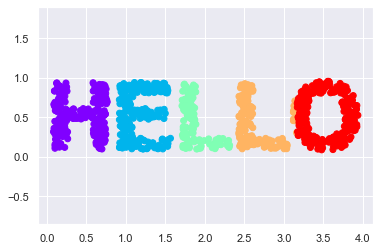

In [3]:
X = make_hello(1000)
colorize = dict(c=X[:, 0], cmap=plt.cm.get_cmap('rainbow', 5))
plt.scatter(X[:, 0], X[:, 1], **colorize)
plt.axis('equal');


The ouput is two dimensional, and consist of points drawn in the shape of the word, "HELLO". This data from will help us to see visually what these algorithms are doing.


## Multidimensional Scaling (MDS)
Looking at data like this, we can see that hte particular choice of * x * and *y * values of the dataset are not the most fundamental description of hte data: we can scale, shring, or rotate the data, and the "HELLO" will still be apparent. For example, if we use a rotation matrix to rotate the data, the * x * and *y * values change, but the data is still fundamentally the same:


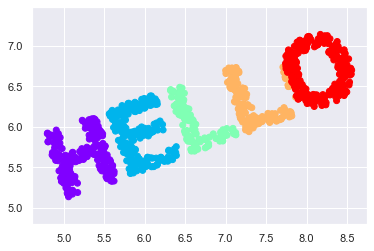

In [4]:
def rotate(X, angle):
    theta = np.deg2rad(angle)
    R = [[np.cos(theta), np.sin(theta)],
         [-np.sin(theta), np.cos(theta)]]

    return np.dot(X, R)


X2 = rotate(X, 20) + 5
plt.scatter(X2[:, 0], X2[:, 1], **colorize)
plt.axis('equal');


This tell us that the * x * and the * y * values are not necessarily fundamental to the relationships in the data. What * is* fundamental, in htis case, is the * distance * between each point and the other points in the dataset. A common way to represent this is to sue a distance matrix: for $N$ points, we construct and $N\times N$ array such theat entr $(i, j)$ contains the distance between point $i$ and point $j$. Let's use Scikit-Learn's efficient `pairwise_distances` function to do this for our original data:


In [5]:
from sklearn.metrics import pairwise_distances
D = pairwise_distances(X)
D.shape

(1000, 1000)

As promised, for our $N = 1000$ points, we obtain a $1000x1000$ matrix, which can be visualized as shown here:


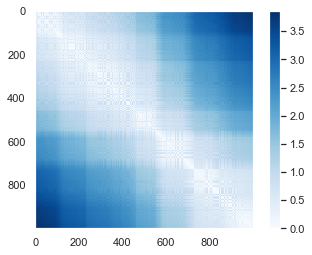

In [6]:
plt.imshow(D, zorder=2, cmap="Blues", interpolation='nearest')
plt.colorbar()

If we similarly construct a distance matrix for our rotated and translated data, we see that it is the same:


In [7]:
D2 = pairwise_distances(X2)
np.allclose(D, D2)

True

This distance matrix gives us a representation of our data that is invariant to rotations and translations, but hte visualization of the matrix above is not entirely intuitive. In the representation shown in this figure, we have lost any visible sign of the interesting structure in the data: the "HELLO" that we saw before.

Further, while computing this distance matrix from the(x, y) coordinate is straightfoward, transforming the distances back into * x * and *y * coordiantes is rather difficult. This is exactly what the multidimensional scaling algorithm aims to do: given a distance matrix between points, it recors a $D$ - dimensional coordinate representation of the data. Let's see how it works for our distance matrix, using the `precomputed` dissimilarity to specify that we are passing a distance matrix:


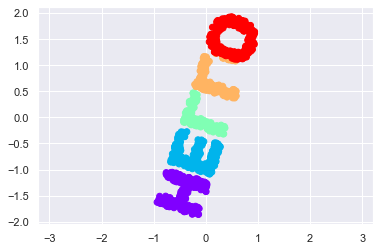

In [8]:
from sklearn.manifold import MDS
model = MDS(n_components=2, dissimilarity='precomputed', random_state=1)
out = model.fit_transform(D)
plt.scatter(out[:, 0], out[:, 1], **colorize)
plt.axis('equal');

The MDS algorithm recors one of the possible two-dimensional coordinate representation of our data, using *only* $N\times N$ distance matrix describing the relationship between the data points.

## MDS as Manifold Learning

The usefulness of this becomes more apparent when we consider the fact that distance matrices can be computed from data in *any* dimension. So, for example, instead of simply rotating the data in two-dimensional plane, we can project it into three dimensions usng the following function (essentially a three-dimensional generalization of the rotation matrix used earlier):

In [9]:
def random_projection(X, dimension=3, rseed=42):
    assert dimension >= X.shape[1]
    rng = np.random.RandomState(rseed)
    C = rng.randn(dimension, dimension)
    e, V = np.linalg.eigh(np.dot(C, C.T))
    return np.dot(X, V[:X.shape[1]])

X3 = random_projection(X, 3)
X3.shape

(1000, 3)

Let's visualize these points to see what we're working with:

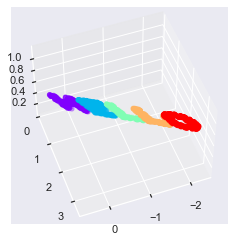

In [10]:
from mpl_toolkits import mplot3d
ax = plt.axes(projection='3d')
ax.scatter3D(X3[:, 0], X3[:, 1], X3[:, 2],
            **colorize)
            
ax.view_init(azim=70, elev=50)            

We can now ask the `MDS` estimator to input this three-dimensional data, compute the distance matrix, and then determine the optimal two-dimensional embedding for this distance matrix. The result recovers a representation of the original data:

(-1.0291497799483875,
 1.0278567681719466,
 -2.0494894050096293,
 2.1202816440434127)

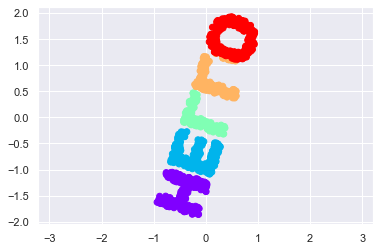

In [11]:
model = MDS(n_components=2, random_state=1)
out3  = model.fit_transform(X3)
plt.scatter(out3[:, 0], out3[:, 1], **colorize)
plt.axis('equal');

This is essentially the gola of a manifold learning estimator: given high-dimensional embedded data, it seeks a low-dimensional representation of the data that preserves certain relationships within the data. In the case of MDS, the quantity preserved is the distance between every pair of points.